# Implement of a Gaussian curvature, mean curvature

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pandas as pd
import skdim

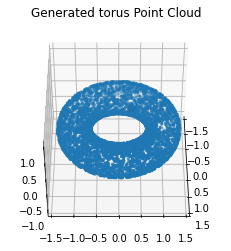

In [14]:
def generate_torus_point_cloud(num_points = 5000, R = 3, r = 1):
    # Generate random angles for theta and phi
    theta = np.random.uniform(0, 2*np.pi, num_points)
    phi = np.random.uniform(0, 2*np.pi, num_points)

    # Compute the torus points
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)
    
    x_c = R * np.cos(theta)
    y_c = R * np.sin(theta)
    z_c = np.zeros(x.shape)
    
    

    return np.column_stack((x, y, z)), np.column_stack((x_c, y_c, z_c))

# Create torus parameters
R = 1 # Major radius
r = 0.375  # Minor radius
num_samples = 5000



# Generate a torus point cloud with 1000 points and radius 1
torus, torus_centers = generate_torus_point_cloud(num_points = num_samples, R = R, r = r)

# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(torus[:, 0], torus[:, 1], torus[:, 2], s=5)
ax.scatter(torus[0, 0], torus[0, 1], torus[0, 2], s=50, c = 'r')
#ax.scatter(torus_centers[:, 0], torus_centers[:, 1], torus_centers[:, 2], s=5, c = 'r')
ax.set_aspect('equal')
ax.set_title("Generated torus Point Cloud")
ax.view_init(45, 0)
plt.show()

In [5]:
def find_basis(point_cloud, x,  extrin_dim = 3, epsilon_PCA = 0.1, tau_radius = 0.4):
    #point_cloud: the manifold 
    #x: np.array of shape 1 by p, the point where the curvature is evaluated at, e.g., [[1, 2, 3]]
    #epsilon: the radius of local PCA
    #dim: the dimension of the manifold
    #tau_ratio: the ratio is tau radius (where we evaluate the curvature)/ epsilon_sqrt
    
    # Find transport neighborhood
    k = int(0.05 * point_cloud.shape[0])

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(point_cloud)
    ep_dist, ep_idx = nbrs.radius_neighbors(x, epsilon_PCA, return_distance=True, sort_results = True)
    
    tau_dist, tau_idx = nbrs.radius_neighbors(x, tau_radius, return_distance=True, sort_results = True)
    
    tau_nbrs = point_cloud[tau_idx[0]]
    
    
    pca_nbrs = point_cloud[ep_idx[0]]
    Xi = pca_nbrs - x
    Di = np.diag(np.sqrt(np.exp(- np.array(ep_dist[0]) ** 2 / epsilon_PCA)))
    Bi = Xi.T @ Di
    
    U, S, VT = np.linalg.svd(Bi.T, full_matrices = False)
    O = VT[:extrin_dim, :]
    
    return tau_nbrs, O
   
    
        
    

In [37]:
def find_basis_align_normal(point_cloud, x, center, extrin_dim = 3, epsilon_PCA = 0.1, tau_radius = 0.4):
    #point_cloud: the manifold 
    #x: np.array of shape 1 by p, the point where the curvature is evaluated at, e.g., [[1, 2, 3]]
    #epsilon: the radius of local PCA
    #dim: the dimension of the manifold
    #tau_ratio: the ratio is tau radius (where we evaluate the curvature)/ epsilon_sqrt
    
    # Find transport neighborhood
    k = int(0.05 * point_cloud.shape[0])

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(point_cloud)
    ep_dist, ep_idx = nbrs.radius_neighbors(x, epsilon_PCA, return_distance=True, sort_results = True)
    
    tau_dist, tau_idx = nbrs.radius_neighbors(x, tau_radius, return_distance=True, sort_results = True)
    
    tau_nbrs = point_cloud[tau_idx[0]]
    
    
    pca_nbrs = point_cloud[ep_idx[0]]
    Xi = pca_nbrs - x
    Di = np.diag(np.sqrt(np.exp(- np.array(ep_dist[0]) ** 2 / epsilon_PCA)))
    Bi = Xi.T @ Di
    
    U, S, VT = np.linalg.svd(Bi.T, full_matrices = False)
    O = VT[:extrin_dim, :]
    if np.dot(x - center, O[2]) > 0:
        O[2] = - O[2]
    
    return tau_nbrs, O
   
    
        
    

In [6]:
def compute_Gaussian_curvature(point_cloud, query_point, extrin_dim = 3, 
                               epsilon_PCA = 0.1, tau_radius = 0.4, max_min_num = 10, use_cross = True):
    
    tau_nbrs, O = find_basis(point_cloud, query_point, extrin_dim = extrin_dim,
                             epsilon_PCA = epsilon_PCA, tau_radius = tau_radius)
            
    if use_cross:
        O2 = np.cross(O[0], O[1])
    else:
        O2 = O[2]

    ti = tau_nbrs[1:] - tau_nbrs[0]
    norms = np.square(ti).sum(axis=1)
    tensor_all = 2 * (O2 * ti).sum(axis=1) / norms

    if max_min_num < 1:
        min_quantile = max_min_num
        max_cur = np.quantile(tensor_all, 1-min_quantile)
        min_cur = np.quantile(tensor_all, min_quantile)
    else:
        max_cur = sum(sorted(tensor_all, reverse=True)[:max_min_num])/max_min_num    
        min_cur = sum(sorted(tensor_all)[:max_min_num])/max_min_num
    
    return max_cur * min_cur
 

In [38]:
def compute_mean_curvature(point_cloud, query_point, center, extrin_dim = 3, 
                           epsilon_PCA = 0.1, tau_radius = 0.4, max_min_num = 10):
    
    tau_nbrs, O = find_basis_align_normal(point_cloud, query_point, center, extrin_dim = extrin_dim,
                                          epsilon_PCA = epsilon_PCA, tau_radius = tau_radius)
    
    O2 = O[2]

    ti = tau_nbrs[1:] - tau_nbrs[0]
    norms = np.square(ti).sum(axis=1)
    tensor_all = 2 * (O2 * ti).sum(axis=1) / norms

    if max_min_num < 1:
        min_quantile = max_min_num
        max_cur = np.quantile(tensor_all, 1-min_quantile)
        min_cur = np.quantile(tensor_all, min_quantile)
    else:
        max_cur = sum(sorted(tensor_all, reverse=True)[:max_min_num])/max_min_num    
        min_cur = sum(sorted(tensor_all)[:max_min_num])/max_min_num
    
    return (max_cur + min_cur)/2
 

## Gaussian curvature 

In [17]:
num_eval = int(len(torus))
curvature = []
for i in tqdm(range(num_eval)):
    b = compute_Gaussian_curvature(torus, torus[i].reshape(1, -1), 
                                   epsilon_PCA =0.2, tau_radius = 1, max_min_num = 120)
    curvature.append(b)

100%|██████████| 5000/5000 [00:13<00:00, 371.61it/s]


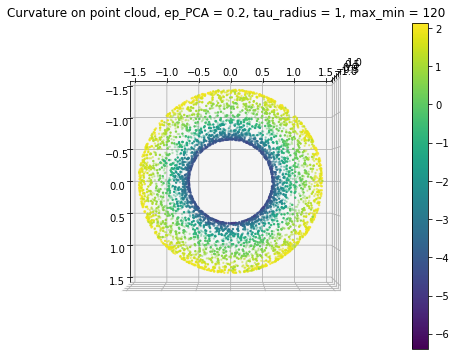

In [18]:
v = np.array(curvature).T
# Visualize the point cloud

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(torus[:num_eval, 0], torus[:num_eval, 1], torus[:num_eval, 2], s=2, c = v)
ax.set_title("Curvature on point cloud, ep_PCA = 0.2, tau_radius = 1, max_min = 120")
ax.view_init(90, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

## Mean curvature

In [39]:
num_eval = int(len(torus))
curvature = []
for i in tqdm(range(num_eval)):
    b = compute_mean_curvature(torus, torus[i].reshape(1, -1), torus_centers[i], 
                               epsilon_PCA =0.2, tau_radius = 1, max_min_num = 120)
    curvature.append(b)

100%|██████████| 5000/5000 [00:13<00:00, 377.82it/s]


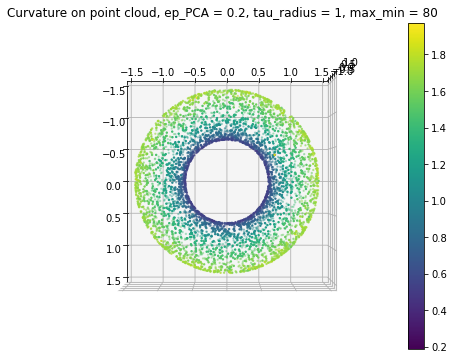

In [40]:
v = np.array(curvature).T
# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(torus[:num_eval, 0], torus[:num_eval, 1], torus[:num_eval, 2], s=2, c = v)
ax.set_title("Curvature on point cloud, ep_PCA = 0.2, tau_radius = 1, max_min = 80")
ax.view_init(90, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

# On different dataset

In [25]:
def generate_ellipsoid_cloud(a, b, c, num_points = 5000):
    """Generate a random point on an ellipsoid defined by a,b,c"""
    
    theta = np.random.uniform(0, 2*np.pi, num_points)
    v = np.random.rand(num_points)
    phi = np.arccos(2.0 * v - 1.0)
    sinTheta = np.sin(theta);
    cosTheta = np.cos(theta);
    sinPhi = np.sin(phi);
    cosPhi = np.cos(phi);
    rx = a * sinPhi * cosTheta;
    ry = b * sinPhi * sinTheta;
    rz = c * cosPhi;
    return np.column_stack((rx, ry, rz))

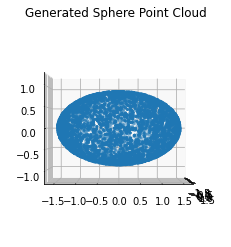

In [26]:
ellipsoid = generate_ellipsoid_cloud(0.9, 1.5, 0.9)

# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ellipsoid[:, 0], ellipsoid[:, 1], ellipsoid[:, 2], s=5)
ax.set_aspect('equal')
ax.set_title("Generated Sphere Point Cloud")
ax.view_init(0, 0)
plt.show()

## Gaussian curvature

In [43]:
num_eval = int(len(ellipsoid))
curvature = []
for i in tqdm(range(num_eval)):
    b = compute_Gaussian_curvature(ellipsoid, ellipsoid[i].reshape(1, -1), 
                                    epsilon_PCA =0.2, tau_radius = 1, max_min_num = 250)
    curvature.append(b)

100%|██████████| 5000/5000 [00:12<00:00, 412.25it/s]


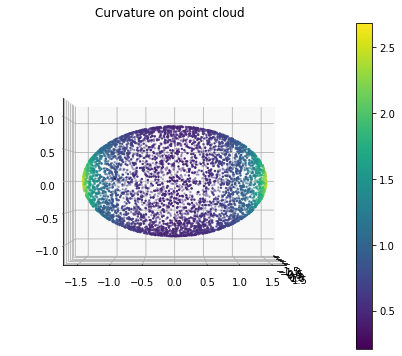

In [44]:
v = np.array(curvature).T
# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(ellipsoid[:num_eval, 0], ellipsoid[:num_eval, 1], ellipsoid[:num_eval, 2], s=2, c = v)
ax.set_title("Curvature on point cloud")
ax.view_init(0, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

## Mean curvature

In [41]:
ellipsoid_center = np.array([0, 0, 0])

num_eval = int(len(ellipsoid))
curvature = []
for i in tqdm(range(num_eval)):
    b = compute_mean_curvature(ellipsoid, ellipsoid[i].reshape(1, -1), ellipsoid_center,
                                    epsilon_PCA =0.2, tau_radius = 1, max_min_num = 200)
    curvature.append(b)

100%|██████████| 5000/5000 [00:11<00:00, 417.47it/s]


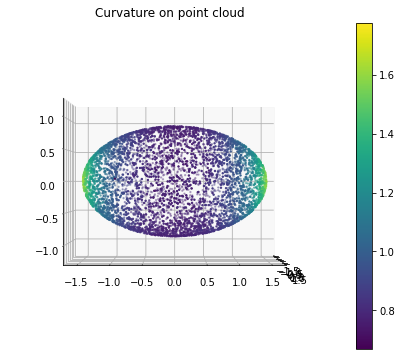

In [42]:
v = np.array(curvature).T
# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(ellipsoid[:num_eval, 0], ellipsoid[:num_eval, 1], ellipsoid[:num_eval, 2], s=2, c = v)
ax.set_title("Curvature on point cloud")
ax.view_init(0, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()